In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


In [11]:
ISBG = pd.read_excel("./data/ISBSG-whole.xlsx",header=3)

In [12]:
cols_needed = ['Max Team Size','COSMIC Read','COSMIC Write','COSMIC Entry','COSMIC Exit','Functional Size','Project Elapsed Time','Development Platform','Primary Programming Language','Summary Work Effort']
ISBG_interest = ISBG[cols_needed]
df_clean = ISBG_interest.dropna(subset=["COSMIC Read", "COSMIC Write", "COSMIC Exit", "COSMIC Entry","Summary Work Effort"])

In [13]:

from sklearn.model_selection import train_test_split

X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

tech_features = ["Development Platform", "Primary Programming Language",
                 "Project Elapsed Time", "Max Team Size"]

functional_features = ["COSMIC Read", "COSMIC Write", "COSMIC Entry", "COSMIC Exit",'Functional Size']

# Split tech and func, training and test sets
X_tech_train = X_train[tech_features]
X_tech_test = X_test[tech_features]

X_func_train = X_train[functional_features]
X_func_test = X_test[functional_features]

# Get numerical and categorical feature names
tech_num_cols = X_tech_train.select_dtypes(include='number').columns
tech_cat_cols = X_tech_train.select_dtypes(exclude='number').columns

func_num_cols = X_func_train.select_dtypes(include='number').columns
func_cat_cols = X_func_train.select_dtypes(exclude='number').columns

# Get right columns
#Tech
X_num_train_tech = X_tech_train[tech_num_cols]
X_num_test_tech = X_tech_test[tech_num_cols]

X_cat_train_tech = X_tech_train[tech_cat_cols]
X_cat_test_tech = X_tech_test[tech_cat_cols]
#func
X_num_train_func = X_func_train[func_num_cols]
X_num_test_func = X_func_test[func_num_cols]

X_cat_train_func = X_func_train[func_cat_cols]
X_cat_test_func = X_func_test[func_cat_cols]



In [29]:
cmp = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)

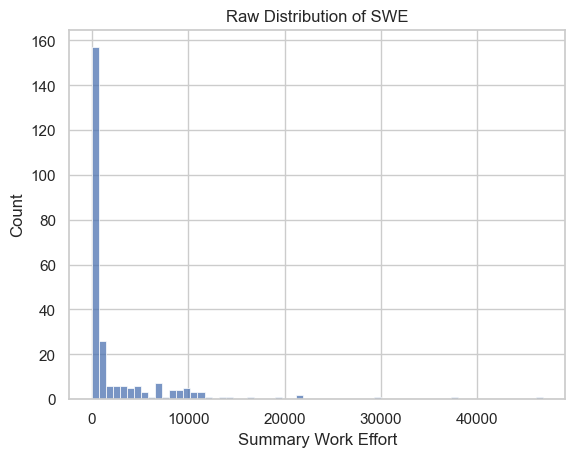

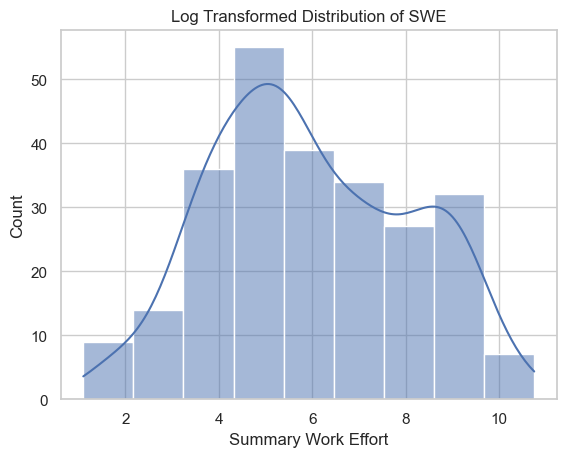

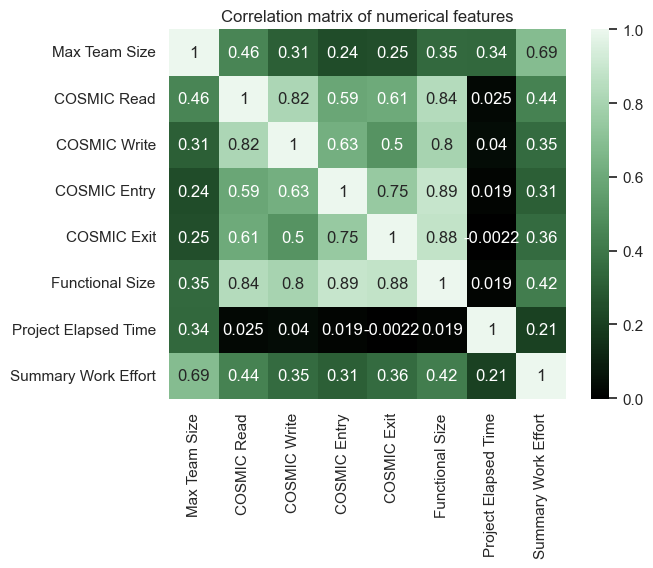

ValueError: Invalid RGBA argument: <matplotlib.colors.ListedColormap object at 0x00000205622EB350>

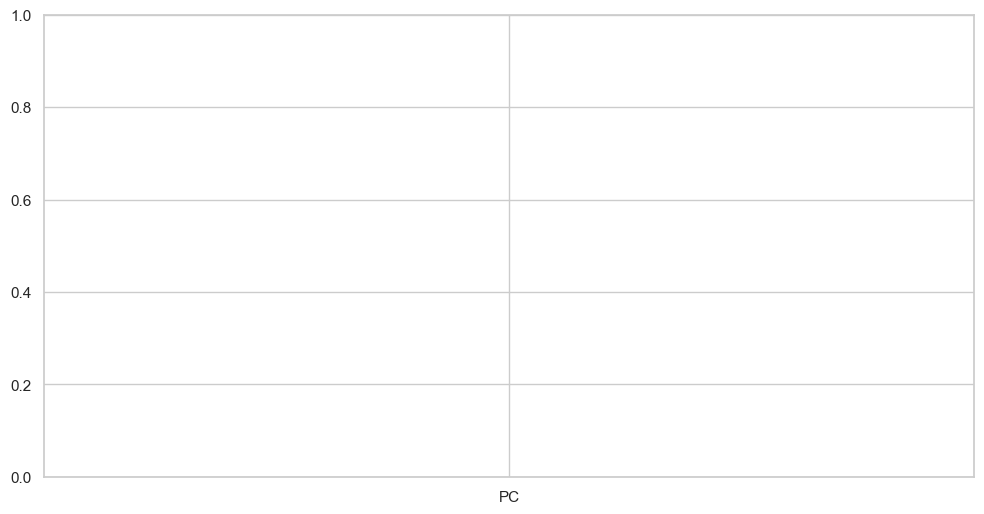

In [39]:

import pandas as pd

plt.figure()
plt.title("Raw Distribution of SWE")
sns.histplot(y_clean)
plt.show()
plt.figure()
plt.title("Log Transformed Distribution of SWE")
sns.histplot(np.log1p(y_clean),kde=True)
plt.show()

corr = df_clean.select_dtypes(include='number').corr()
plt.figure()
plt.title("Correlation matrix of numerical features")

sns.heatmap(corr, annot=True, cmap=cmp)
plt.show()

# sns.pairplot(df_clean)
plt.figure(figsize=(12,6))
sns.boxplot(
    data=df_clean,
    x="Development Platform",
    y="Summary Work Effort",
)
plt.xticks(rotation=45)
plt.title("SWE by Development Platform")
plt.show()



In [15]:
# Assuming your DataFrame is named df_clean (or replace with your DataFrame variable)

# 1. Get the count of missing values per column
missing_counts = df_clean.isnull().sum()

# 2. (Optional) Also get the percentage of missing values per column
missing_pct = df_clean.isnull().mean() * 100

# 3. Combine into a single DataFrame for a neat display
missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_pct': missing_pct
})

print(missing_summary)


                              missing_count  missing_pct
Max Team Size                            86    33.992095
COSMIC Read                               0     0.000000
COSMIC Write                              0     0.000000
COSMIC Entry                              0     0.000000
COSMIC Exit                               0     0.000000
Functional Size                           0     0.000000
Project Elapsed Time                     20     7.905138
Development Platform                     60    23.715415
Primary Programming Language             16     6.324111
Summary Work Effort                       0     0.000000


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder

X_clean = df_clean.drop(columns=["Summary Work Effort"])
y_clean = df_clean["Summary Work Effort"]

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

all_numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
all_categorical_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

tech_features_orig = ["Development Platform", "Primary Programming Language",
                      "Project Elapsed Time", "Max Team Size"]
functional_features_orig = ["COSMIC Read", "COSMIC Write", "COSMIC Entry",
                            "COSMIC Exit",'Functional Size']

numeric_pipeline_steps = [
    ('imputer', KNNImputer(n_neighbors=5)),
    ('log1p', FunctionTransformer(np.log1p, validate=False, feature_names_out='one-to-one')),
    ('scaler', StandardScaler())
]
numeric_pipeline = Pipeline(numeric_pipeline_steps)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

tech_num_cols = [col for col in tech_features_orig if col in all_numeric_cols]
tech_cat_cols = [col for col in tech_features_orig if col in all_categorical_cols]
func_num_cols = [col for col in functional_features_orig if col in all_numeric_cols]
func_cat_cols = [col for col in functional_features_orig if col in all_categorical_cols]

numeric_cols_for_preprocessing = tech_num_cols + func_num_cols
categorical_cols_for_preprocessing = tech_cat_cols + func_cat_cols

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_cols_for_preprocessing),
        ('cat', categorical_pipeline, categorical_cols_for_preprocessing)
    ],
)

X_train_prepared = preprocessor.fit_transform(X_train)
X_test_prepared = preprocessor.transform(X_test)

feature_names_out = preprocessor.get_feature_names_out()

X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=feature_names_out, index=X_train.index)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=feature_names_out, index=X_test.index)

tech_prepared_cols = []
func_prepared_cols = []


# Thanks to chatgpt for this piece:
for col_name in feature_names_out:
    parts = col_name.split('__')
    if len(parts) > 1:
        original_feature = parts[1].split('_')[0] # Basic extraction, might need refinement if feature names contain underscores
        # More robust extraction if needed:
        # Check if original_feature exists in numeric/categorical lists before assigning
        if parts[0] == 'num': # Check if it came from the numeric pipeline
             # Find the original name (assuming it's the second part)
             original_feature = parts[1]
        elif parts[0] == 'cat': # Check if it came from the categorical pipeline
             # OneHotEncoder adds the category value, find the base feature name
             # Find the original feature name that this encoded column belongs to
             original_feature = next((cat_col for cat_col in categorical_cols_for_preprocessing if col_name.startswith(f"cat__{cat_col}_")), None)
             if original_feature is None and col_name.split('__')[1] in categorical_cols_for_preprocessing:
                  # Handle cases where OHE might not add _category (e.g., binary features, drop='if_binary') - less common with sparse_output=False
                  original_feature = col_name.split('__')[1]

        if original_feature in tech_features_orig:
            tech_prepared_cols.append(col_name)
        elif original_feature in functional_features_orig:
            func_prepared_cols.append(col_name)

X_train_tech = X_train_prepared_df[tech_prepared_cols]
X_test_tech = X_test_prepared_df[tech_prepared_cols]

X_train_func = X_train_prepared_df[func_prepared_cols]
X_test_func = X_test_prepared_df[func_prepared_cols]

print("\n Separate datasets for tech and func features:")
print("Shape of X_train_tech:", X_train_tech.shape)
print("Shape of X_test_tech:", X_test_tech.shape)
print("Shape of X_train_func:", X_train_func.shape)
print("Shape of X_test_func:", X_test_func.shape)



 Separate datasets for tech and func features:
Shape of X_train_tech: (202, 25)
Shape of X_test_tech: (51, 25)
Shape of X_train_func: (202, 5)
Shape of X_test_func: (51, 5)


In [43]:
import xgboost as xgboost
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print(f"True mean of SWE {df_clean['Summary Work Effort'].mean()} standard_deviation SWE {df_clean['Summary Work Effort'].std()}\n")
def evaluate_model(model_name,y_true,y_pred_log):
    y_pred = np.expm1(y_pred_log)
    # y_pred = np.max(0,y_pred)
    mse = mean_squared_error(y_true,y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true,y_pred)
    mae = mean_absolute_error(y_true,y_pred)
    print(f"\nModel: {model_name}, mse : {mse}, r2 : {r2}, mae : {mae}, rmse {rmse}")
    return mse,r2,mae

DTR = DecisionTreeRegressor(random_state=42)
dtr_model_tech = DTR.fit(X_train_tech,y_train_log)
dtr_pred_log_tech = dtr_model_tech.predict(X_test_tech)
results_dtr_tech = evaluate_model("DTR_tech",y_test,dtr_pred_log_tech)

dtr_model_func = DTR.fit(X_train_func,y_train_log)
dtr_pred_log_func = dtr_model_func.predict(X_test_func)
results_dtr_func = evaluate_model("DTR_func",y_test,dtr_pred_log_func)

xgb = xgboost.XGBRegressor(objective="reg:squarederror",random_state=42)
xgb_model_tech = xgb.fit(X_train_tech,y_train_log)
xgb_pred_log_tech = xgb_model_tech.predict(X_test_tech)
results_xgb_tech = evaluate_model("XGB_tech",y_test,xgb_pred_log_tech)

xgb_model_func = xgb.fit(X_train_func,y_train_log)
xgb_pred_log_func = xgb_model_func.predict(X_test_func)
results_xgb_func = evaluate_model("XGB_func",y_test,xgb_pred_log_func)

predictions = [(dtr_pred_log_tech,"DTR_tech"),(dtr_pred_log_func,"DTR_func"),(xgb_pred_log_tech,"XGB_tech"),(xgb_pred_log_func,"XGB_func")]


True mean of SWE 2545.9723320158105 standard_deviation SWE 5514.492199421938


Model: DTR_tech, mse : 37931350.105368115, r2 : 0.2335303831862876, mae : 2113.089172304204, rmse 6158.8432440977185

Model: DTR_func, mse : 45335792.2415504, r2 : 0.08391061191334892, mae : 2279.092163519397, rmse 6733.185890910067

Model: XGB_tech, mse : 38975909.55907181, r2 : 0.2124232229614239, mae : 1906.210646498437, rmse 6243.0689215378525

Model: XGB_func, mse : 48923715.74191453, r2 : 0.011410309581852851, mae : 2393.632090250651, rmse 6994.549002038269


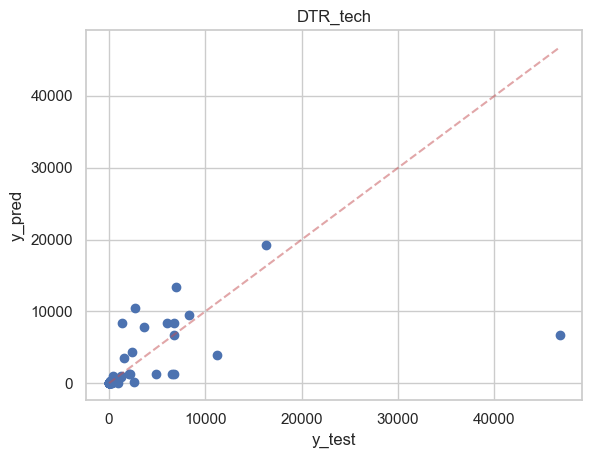

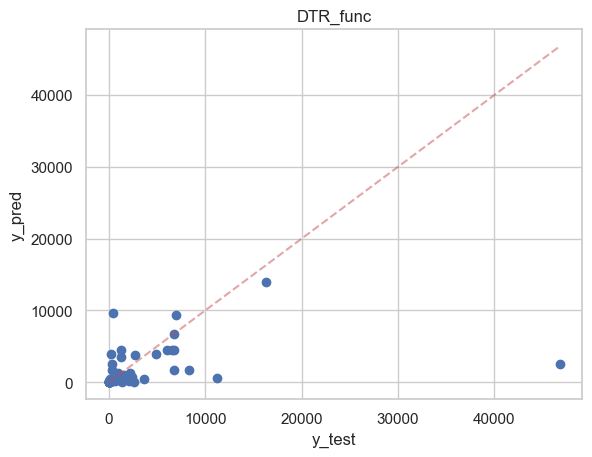

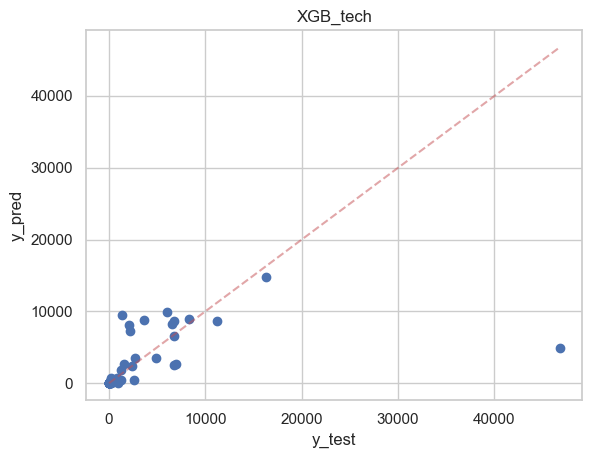

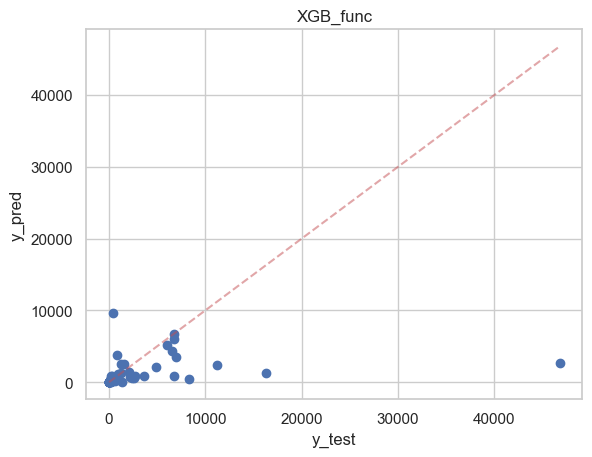

In [47]:
def pred_act(y_test,y_pred,label):
    plt.figure()
    plt.title(label)
    plt.scatter(y_test,y_pred)
    max_val = y_test.max()
    min_val = y_test.min()
    plt.plot([min_val,max_val],[min_val,max_val], 'r--',alpha=0.5,label=f"Perfect fit")
    plt.xlabel("y_test")
    plt.ylabel("y_pred")
    plt.show()

for prediction in predictions:
    pred_act(y_test,np.expm1(prediction[0]),prediction[1])

Best DTR tech: {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best DTR func: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best XGB tech: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGB func: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

=== Final test performance (after grid search) ===

Model: DTR_tech (GS), mse : 37388643.34262642, r2 : 0.24449672747209172, mae : 1847.57520409642, rmse 6114.625364045325

Model: DTR_func (GS), mse : 42696594.522427104, r2 : 0.1372402418593649, mae : 2347.112982465331, rmse 6534.263120079196

Model: XGB_tech (GS), mse : 38770120.982825756, r2 : 0.21658154294586407, mae : 1964.8140569574693, rmse 6226.56574548328

Model: XGB_func (GS), mse : 45341274.26527108, r2 : 0.08379983798600688, mae : 2376.1983079349293, rmse 6733.592968488004


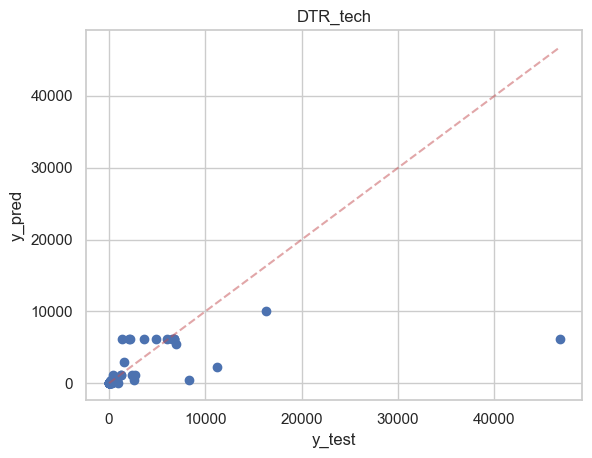

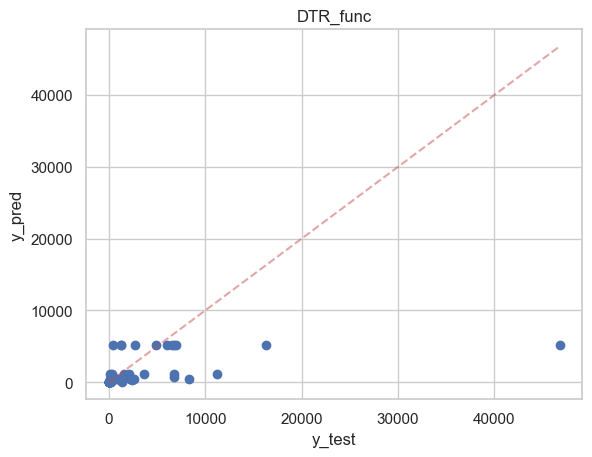

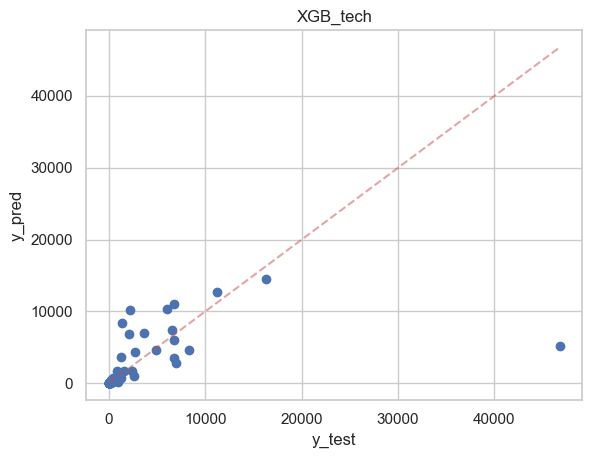

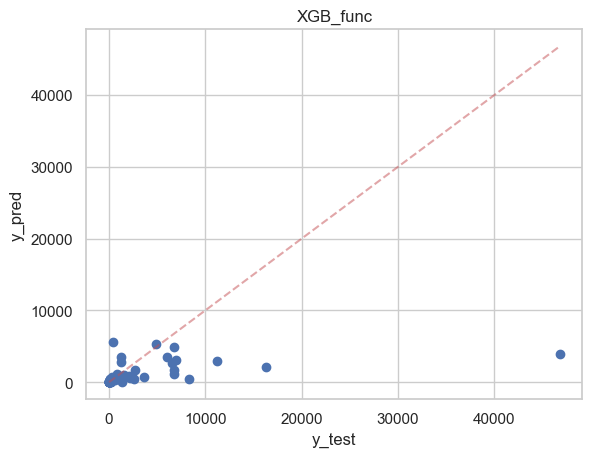

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

# --- 1) Define param grids ---
param_grid_dtr = {
    'max_depth':      [None, 3,4, 5,6,7,8,9, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}

param_grid_xgb = {
    'n_estimators':   [100, 200, 300,400,500],
    'max_depth':      [3, 5, 7],
    'learning_rate':  [0.01, 0.1, 0.2],
    'subsample':      [0.8, 1.0]
}

# --- 2) Set up GridSearchCV for each model / feature set ---
# Decision Tree on tech features
grid_dtr_tech = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dtr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_tech.fit(X_train_tech, y_train_log)

# Decision Tree on func features
grid_dtr_func = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=param_grid_dtr,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_dtr_func.fit(X_train_func, y_train_log)

# XGB on tech features
grid_xgb_tech = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_tech.fit(X_train_tech, y_train_log)

# XGB on func features
grid_xgb_func = GridSearchCV(
    xgb.XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid=param_grid_xgb,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
grid_xgb_func.fit(X_train_func, y_train_log)

# --- 3) Inspect best params ---
print("Best DTR tech:", grid_dtr_tech.best_params_)
print("Best DTR func:", grid_dtr_func.best_params_)
print("Best XGB tech:", grid_xgb_tech.best_params_)
print("Best XGB func:", grid_xgb_func.best_params_)

# --- 4) Evaluate on the hold-out test set ---
best_dtr_tech = grid_dtr_tech.best_estimator_
best_dtr_func = grid_dtr_func.best_estimator_
best_xgb_tech = grid_xgb_tech.best_estimator_
best_xgb_func = grid_xgb_func.best_estimator_

dtr_tech_pred = best_dtr_tech.predict(X_test_tech)
dtr_func_pred = best_dtr_func.predict(X_test_func)
xgb_tech_pred = best_xgb_tech.predict(X_test_tech)
xgb_func_pred = best_xgb_func.predict(X_test_func)

print("\n=== Final test performance (after grid search) ===")
evaluate_model("DTR_tech (GS)", y_test, dtr_tech_pred)
evaluate_model("DTR_func (GS)", y_test, dtr_func_pred)
evaluate_model("XGB_tech (GS)", y_test, xgb_tech_pred)
evaluate_model("XGB_func (GS)", y_test, xgb_func_pred)


predictions2 = [(dtr_tech_pred,"DTR_tech"),(dtr_func_pred,"DTR_func"),(xgb_tech_pred,"XGB_tech"),(xgb_func_pred,"XGB_func")]

for prediction in predictions2:
    pred_act(y_test,np.expm1(prediction[0]),prediction[1])


In [10]:
import keras
from keras import layers
from keras.api.callbacks import EarlyStopping
from keras._tf_keras.keras.losses import huber

## TECH ##
X_train_keras_tech = X_train_tech.values.astype(np.float32)
X_test_keras_tech = X_test_tech.values.astype(np.float32)

## FUNC ##
X_train_keras_func = X_train_func.values.astype(np.float32)
X_test_keras_func = X_test_func.values.astype(np.float32)

## BOTH ##

X_train_keras_combined = pd.concat([X_train_tech, X_train_func], axis=1).values.astype(np.float32)
X_test_keras_combined = pd.concat([X_test_tech, X_test_func], axis=1).values.astype(np.float32)

y_train_log_keras = y_train_log.astype(np.float32)

input_shape_tech = (X_train_keras_tech.shape[1],)
input_shape_func = (X_train_keras_func.shape[1],)
input_shape_comb = (X_train_keras_combined.shape[1],)

# Define the model TECH
keras_model_tech = keras.Sequential(
    [
        layers.Input(shape=input_shape_tech),
        layers.Dense(32, activation="relu"),
        # layers.Dropout(0.3), # Add dropout for regularization
        # layers.Dense(64, activation="relu"),
        # layers.Dropout(0.3),
        layers.Dense(1),
    ]
)

# Define the model FUNC
keras_model_func = keras.Sequential(
    [
        layers.Input(shape=input_shape_func),
        layers.Dense(32, activation="relu"),
        # layers.Dropout(0.1), # Add dropout for regularization
        # layers.Dense(128, activation="relu"),
        # layers.Dropout(0.3),
        # layers.Dense(128, activation="relu"),
        # layers.Dropout(0.3),
        layers.Dense(1),
    ]
)
# Define the model FUNC
keras_model_comb = keras.Sequential(
    [
        layers.Input(shape=input_shape_comb),
        layers.Dense(32, activation="relu"),
        # layers.Dropout(0.1), # Add dropout for regularization
        # layers.Dense(128, activation="relu"),
        # layers.Dropout(0.3),
        # layers.Dense(128, activation="relu"),
        # layers.Dropout(0.3),
        layers.Dense(1),
    ]
)

# Compile the model
keras_model_tech.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), # Adam optimizer
    loss=huber,  # Good tradeoff between MAE and MSE
)
# Compile the model
keras_model_func.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=huber,
)
# Compile the model
keras_model_comb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=huber,
)

# Define Early Stopping callback
early_stopping_cb = EarlyStopping(
    monitor='val_loss', # Monitor validation loss
    patience=20,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True, # Restore model weights from the epoch with the best value
    verbose=1
)
#
# print("Keras TECH Model Summary:")
# keras_model_tech.summary()
#
# print("Keras FUNC Model Summary:")
# keras_model_func.summary()

# Train the TECH model
history_tech = keras_model_tech.fit(
    X_train_keras_tech,
    y_train_log_keras,
    epochs=150, # Max number of epochs
    batch_size=16,
    validation_split=0.15, # Use 15% of training data for validation
    callbacks=[early_stopping_cb],
    verbose=1, # Set to 1 or 2 to see epoch progress
)
# # Train the FUNC model
history_func = keras_model_func.fit(
    X_train_keras_func,
    y_train_log_keras,
    epochs=150, # Max number of epochs
    batch_size=16,
    validation_split=0.15, # Use 15% of training data for validation
    callbacks=[early_stopping_cb],
    verbose=1, # Set to 1 or 2 to see epoch progress
)
# # Train the FUNC model
history_comb = keras_model_comb.fit(
    X_train_keras_combined,
    y_train_log_keras,
    epochs=150, # Max number of epochs
    batch_size=16,
    validation_split=0.15, # Use 15% of training data for validation
    callbacks=[early_stopping_cb],
    verbose=1, # Set to 1 or 2 to see epoch progress
)




# Evaluate the TECH model
keras_preds_log_tech = keras_model_tech.predict(X_test_keras_tech).flatten() # Predict and flatten output


# Evaluate the TECH model
keras_preds_log_comb = keras_model_comb.predict(X_test_keras_combined).flatten() # Predict and flatten output




# Evaluate the TECH model
keras_preds_log_func = keras_model_func.predict(X_test_keras_func).flatten() # Predict and flatten output
print(f"Keras FUNC training stopped after {len(history_func.history['loss'])} epochs.")
evaluate_model(f"MLP_func", y_test, keras_preds_log_func)
print(f"Keras TECH training stopped after {len(history_tech.history['loss'])} epochs.")
evaluate_model(f"MLP_tech", y_test, keras_preds_log_tech)
print(f"Keras COMB training stopped after {len(history_tech.history['loss'])} epochs.")
evaluate_model(f"MLP_comb", y_test, keras_preds_log_comb)


Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 5.4783 - val_loss: 5.5086
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.1358 - val_loss: 5.3007
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.2565 - val_loss: 5.0965
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.0652 - val_loss: 4.8883
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.8598 - val_loss: 4.6788
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.2626 - val_loss: 4.4598
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.1603 - val_loss: 4.2363
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.2329 - val_loss: 4.0104
Epoch 9/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.7588 - val_loss: 3.7763
Epoch 10/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8127 - val_loss: 3.5352
Epoch 11/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.4971 - val_loss: 3.2870
Epoch 12/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

(28789450.71286396, 0.418258532984745, 1599.851739285039)